In [1]:
import numpy
from pylab import *
import copy

# 定义一个含有障碍物的20×20的栅格地图
# 10表示可通行点
# 0表示障碍物
# 7表示起点
# 5表示终点
map_grid = numpy.full((20, 20), int(10), dtype=numpy.int8)
map_grid[3, 3:8] = 0
map_grid[3:10, 7] = 0
map_grid[10, 3:8] = 0
map_grid[17, 13:17] = 0
map_grid[10:17, 13] = 0
map_grid[10, 13:17] = 0
map_grid[5, 2] = 7
map_grid[15, 15] = 5


class AStar(object):
    """
    创建一个A*算法类
    """

    def __init__(self):
        """
        初始化
        """
        # self.g = 0  # g初始化为0
        self.start = numpy.array([5, 2])  # 起点坐标
        self.goal = numpy.array([15, 15])  # 终点坐标
        self.open = numpy.array([[], [], [], [], [], []])  # 先创建一个空的open表, 记录坐标，方向，g值，f值
        self.closed = numpy.array([[], [], [], [], [], []])  # 先创建一个空的closed表
        self.best_path_array = numpy.array([[], []])  # 回溯路径表

    def h_value_tem(self, son_p):
        """
        计算拓展节点和终点的h值
        :param son_p:子搜索节点坐标
        :return:
        """
        h = (son_p[0] - self.goal[0]) ** 2 + (son_p[1] - self.goal[1]) ** 2
        h = numpy.sqrt(h)  # 计算h
        return h

    # def g_value_tem(self, son_p, father_p):
    #     """
    #     计算拓展节点和父节点的g值
    #     其实也可以直接用1或者1.414代替
    #     :param son_p:子节点坐标
    #     :param father_p:父节点坐标，也就是self.current_point
    #     :return:返回子节点到父节点的g值，但不是全局g值
    #     """
    #     g1 = father_p[0] - son_p[0]
    #     g2 = father_p[1] - son_p[1]
    #     g = g1 ** 2 + g2 ** 2
    #     g = numpy.sqrt(g)
    #     return g

    def g_accumulation(self, son_point, father_point):
        """
        累计的g值
        :return:
        """
        g1 = father_point[0] - son_point[0]
        g2 = father_point[1] - son_point[1]
        g = g1 ** 2 + g2 ** 2
        g = numpy.sqrt(g) + father_point[4]  # 加上累计的g值
        return g

    def f_value_tem(self, son_p, father_p):
        """
        求出的是临时g值和h值加上累计g值得到全局f值
        :param father_p: 父节点坐标
        :param son_p: 子节点坐标
        :return:f
        """
        f = self.g_accumulation(son_p, father_p) + self.h_value_tem(son_p)
        return f

    def child_point(self, x):
        """
        拓展的子节点坐标
        :param x: 父节点坐标
        :return: 子节点存入open表，返回值是每一次拓展出的子节点数目，用于撞墙判断
        当搜索的节点撞墙后，如果不加处理，会陷入死循环
        """
        # 开始遍历周围8个节点
        for j in range(-1, 2, 1):
            for q in range(-1, 2, 1):

                if j == 0 and q == 0:  # 搜索到父节点去掉
                    continue
                m = [x[0] + j, x[1] + q]
                #print(m)
                if m[0] < 0 or m[0] > 19 or m[1] < 0 or m[1] > 19:  # 搜索点出了边界去掉
                    continue

                if map_grid[int(m[0]), int(m[1])] == 0:  # 搜索到障碍物去掉
                    continue



                record_g = self.g_accumulation(m, x)
                record_f = self.f_value_tem(m, x)  # 计算每一个节点的f值

                x_direction, y_direction = self.direction(x, m)  # 每产生一个子节点，记录一次方向

                para = [m[0], m[1], x_direction, y_direction, record_g, record_f]  # 将参数汇总一下
                #print(para)

                # 在open表中，则去掉搜索点，但是需要更新方向指针和self.g值
                # 而且只需要计算并更新self.g即可，此时建立一个比较g值的函数
                a, index = self.judge_location(m, self.open)
                if a == 1:
                    # 说明open中已经存在这个点

                    if record_f <= self.open[5][index]:
                        self.open[5][index] = record_f
                        self.open[4][index] = record_g
                        self.open[3][index] = y_direction
                        self.open[2][index] = x_direction

                    continue

                # 在closed表中,则去掉搜索点
                b, index2 = self.judge_location(m, self.closed)
                if b == 1:

                    if record_f <= self.closed[5][index2]:
                        self.closed[5][index2] = record_f
                        self.closed[4][index2] = record_g
                        self.closed[3][index2] = y_direction
                        self.closed[2][index2] = x_direction
                        self.closed = numpy.delete(self.closed, index2, axis=1)
                        self.open = numpy.c_[self.open, para]
                    continue

                self.open = numpy.c_[self.open, para]  # 参数添加到open中
                #print(self.open)

    def judge_location(self, m, list_co):
        """
        判断拓展点是否在open表或者closed表中
        :return:返回判断是否存在，和如果存在，那么存在的位置索引
        """
        jud = 0
        index = 0
        for i in range(list_co.shape[1]):

            if m[0] == list_co[0, i] and m[1] == list_co[1, i]:

                jud = jud + 1

                index = i
                break
            else:
                jud = jud
        # if a != 0:
        #     continue
        return jud, index

    def direction(self, father_point, son_point):
        """
        建立每一个节点的方向，便于在closed表中选出最佳路径
        非常重要的一步，不然画出的图像参考1.1版本
        x记录子节点和父节点的x轴变化
        y记录子节点和父节点的y轴变化
        如（0，1）表示子节点在父节点的方向上变化0和1
        :return:
        """
        x = son_point[0] - father_point[0]
        y = son_point[1] - father_point[1]
        return x, y

    def path_backtrace(self):
        """
        回溯closed表中的最短路径
        :return:
        """
        best_path = [15, 15]  # 回溯路径的初始化
        self.best_path_array = numpy.array([[15], [15]])
        j = 0
        while j <= self.closed.shape[1]:
            for i in range(self.closed.shape[1]):
                if best_path[0] == self.closed[0][i] and best_path[1] == self.closed[1][i]:
                    x = self.closed[0][i]-self.closed[2][i]
                    y = self.closed[1][i]-self.closed[3][i]
                    best_path = [x, y]
                    self.best_path_array = numpy.c_[self.best_path_array, best_path]
                    break  # 如果已经找到，退出本轮循环，减少耗时
                else:
                    continue
            j = j+1
        # return best_path_array

    def main(self):
        """
        main函数
        :return:
        """
        best = self.start  # 起点放入当前点，作为父节点
        h0 = self.h_value_tem(best)
        init_open = [best[0], best[1], 0, 0, 0, h0]  # 将方向初始化为（0，0），g_init=0,f值初始化h0
        self.open = numpy.column_stack((self.open, init_open))  # 起点放入open,open初始化

        ite = 1  # 设置迭代次数小于200，防止程序出错无限循环
        while ite <= 1000:

                # open列表为空，退出
                if self.open.shape[1] == 0:
                    print('没有搜索到路径！')
                    return

                self.open = self.open.T[numpy.lexsort(self.open)].T  # open表中最后一行排序(联合排序）

                # 选取open表中最小f值的节点作为best，放入closed表

                best = self.open[:, 0]
                print('检验第%s次当前点坐标*******************' % ite)
                print(best)
                self.closed = numpy.c_[self.closed, best]

                if best[0] == 15 and best[1] == 15:  # 如果best是目标点，退出
                    print('搜索成功！')
                    return

                self.child_point(best)  # 生成子节点并判断数目
                #print(self.open)
                self.open = numpy.delete(self.open, 0, axis=1)  # 删除open中最优点

                # print(self.open)

                ite = ite+1

In [2]:
class MAP(object):
    """
    画出地图
    """
    def draw_init_map(self):
        """
        画出起点终点图
        :return:
        """
        plt.imshow(map_grid, cmap=plt.cm.hot, interpolation='nearest', vmin=0, vmax=10)
        # plt.colorbar()
        xlim(-1, 20)  # 设置x轴范围
        ylim(-1, 20)  # 设置y轴范围
        my_x_ticks = numpy.arange(0, 20, 1)
        my_y_ticks = numpy.arange(0, 20, 1)
        plt.xticks(my_x_ticks)
        plt.yticks(my_y_ticks)
        plt.grid(True)
        # plt.show()

    def draw_path_open(self, a):
        """
        画出open表中的坐标点图
        :return:
        """
        map_open = copy.deepcopy(map_grid)
        for i in range(a.closed.shape[1]):
            x = a.closed[:, i]

            map_open[int(x[0]), int(x[1])] = 1

        plt.imshow(map_open, cmap=plt.cm.hot, interpolation='nearest', vmin=0, vmax=10)
        # plt.colorbar()
        xlim(-1, 20)  # 设置x轴范围
        ylim(-1, 20)  # 设置y轴范围
        my_x_ticks = numpy.arange(0, 20, 1)
        my_y_ticks = numpy.arange(0, 20, 1)
        plt.xticks(my_x_ticks)
        plt.yticks(my_y_ticks)
        plt.grid(True)
        # plt.show()

    def draw_path_closed(self, a):
        """
        画出closed表中的坐标点图
        :return:
        """
        print('打印closed长度：')
        print(a.closed.shape[1])
        map_closed = copy.deepcopy(map_grid)
        for i in range(a.closed.shape[1]):
            x = a.closed[:, i]

            map_closed[int(x[0]), int(x[1])] = 5

        plt.imshow(map_closed, cmap=plt.cm.hot, interpolation='nearest', vmin=0, vmax=10)
        # plt.colorbar()
        xlim(-1, 20)  # 设置x轴范围
        ylim(-1, 20)  # 设置y轴范围
        my_x_ticks = numpy.arange(0, 20, 1)
        my_y_ticks = numpy.arange(0, 20, 1)
        plt.xticks(my_x_ticks)
        plt.yticks(my_y_ticks)
        plt.grid(True)
        # plt.show()

    def draw_direction_point(self, a):
        """
        从终点开始，根据记录的方向信息，画出搜索的路径图
        :return:
        """
        #print('打印direction长度：')
        #print(a.best_path_array.shape[1])
        map_direction = copy.deepcopy(map_grid)
        for i in range(a.best_path_array.shape[1]):
            x = a.best_path_array[:, i]

            map_direction[int(x[0]), int(x[1])] = 6

        plt.imshow(map_direction, cmap=plt.cm.hot, interpolation='nearest', vmin=0, vmax=10)
        # plt.colorbar()
        xlim(-1, 20)  # 设置x轴范围
        ylim(-1, 20)  # 设置y轴范围
        my_x_ticks = numpy.arange(0, 20, 1)
        my_y_ticks = numpy.arange(0, 20, 1)
        plt.xticks(my_x_ticks)
        plt.yticks(my_y_ticks)
        plt.grid(True)

    def draw_three_axes(self, a):
        """
        将三张图画在一个figure中
        :return:
        """
        plt.figure()
        ax1 = plt.subplot(221)
        ax2 = plt.subplot(222)
        ax3 = plt.subplot(223)
        ax4 = plt.subplot(224)
        plt.sca(ax1)
        self.draw_init_map()
        plt.sca(ax2)
        self.draw_path_open(a)
        plt.sca(ax3)
        self.draw_path_closed(a)
        plt.sca(ax4)
        self.draw_direction_point(a)

        plt.show()

检验第1次当前点坐标*******************
[ 5.          2.          0.          0.          0.         16.40121947]
检验第2次当前点坐标*******************
[ 6.          3.          1.          1.          1.41421356 16.41421356]
检验第3次当前点坐标*******************
[ 7.          4.          1.          1.          2.82842712 16.42989763]
检验第4次当前点坐标*******************
[ 8.          5.          1.          1.          4.24264069 16.4491963 ]
检验第5次当前点坐标*******************
[ 9.          6.          1.          1.          5.65685425 16.47350808]
检验第6次当前点坐标*******************
[ 5.          3.          0.          1.          1.         16.62049935]
检验第7次当前点坐标*******************
[ 6.          4.          1.          1.          2.41421356 16.62688397]
检验第8次当前点坐标*******************
[ 7.          5.          1.          1.          3.82842712 16.6346756 ]
检验第9次当前点坐标*******************
[ 8.          6.          1.          1.          5.24264069 16.64439494]
检验第10次当前点坐标*******************
[ 6.         2.         1.       

打印closed长度：
272


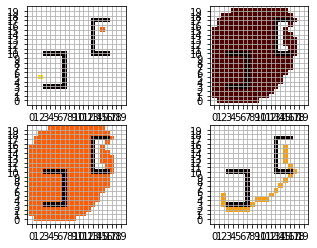

In [3]:
if __name__ == '__main__':

    a1 = AStar()
    a1.main()
    a1.path_backtrace()
    m1 = MAP()
    m1.draw_three_axes(a1)